<a href="https://colab.research.google.com/github/benon33/w207-final/blob/main/EK_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
%matplotlib inline

!sudo pip install geonamescache

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import collections
import itertools
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

     |████████████████████████████████| 2.6 MB 8.6 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#import data
train_data =  pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')

In [3]:
#determine the shape of the dataset 
train_data.shape[0], train_data.shape[1]

(7613, 5)

In [4]:
#plot first 5 rows in dataset
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#plot random 5 rows in dataset 
train_data.sample(5)

,id,keyword,location,text,target
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit g...,0
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...,0
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0


In [5]:
#understand the counts of missing values in dataset 
num_cols = list(train_data.columns)
null_val={}

for col in num_cols:
    null_val[col]=len(train_data[train_data[col].isnull()==True])
    print(col,':',null_val[col])

id : 0
keyword : 61
location : 2533
text : 0
target : 0


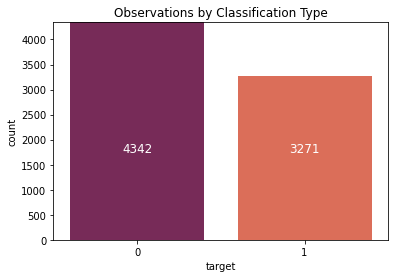

In [6]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart 

#explore distribution of dataset 

sns.countplot(x = train_data['target'], palette = 'rocket')
ax = plt.gca()
y_max = train_data['target'].value_counts().max() 
ax.set_ylim([0, round(y_max)])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 1700, '%d' % int(p.get_height()), 
            fontsize=12, color='white', ha='center', va= 'bottom')
plt.title("Observations by Classification Type")
plt.show()

In [12]:
#CREDIT TO SOURCE: https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe
# look for duplication in dataset 

duplct_cnt = len(train_data['text'])-len(train_data['text'].drop_duplicates())
duplct_cnt

110

In [13]:
#CREDIT TO SOURCES: 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html 

#create a flag for duplicate tweets
df = train_data
df['duplicate_tweet'] = np.where(df['text'].duplicated(keep=False), 'yes', 'no')
df

,id,keyword,location,text,target,clean_text,duplicate_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,no
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,no
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria_ahrary thetawniest the out of control wil...,yes
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s of volcano hawaii httptcozdtoydebj,yes
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,yes


In [14]:
#look for most common duplicate tweet
df[df.duplicate_tweet == 'yes'].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False)


,target
text,
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,5
...,...
General News Û¢åÊ'Demolition of houses on waterways begins at Achimota Mile 7 ' via @233liveOnline. Full story at http://t.co/iO7kUUg1uq,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it!,2


In [15]:
#check if duplicates are classified the same way

dups = df[df.duplicate_tweet == 'yes']
dups2 = dups[['id', 'text', 'target']].sort_values(by='text', ascending=False)
dups2

,id,text,target
5620,8018,wowo--=== 12000 Nigerian refugees repatriated ...,1
5641,8044,wowo--=== 12000 Nigerian refugees repatriated ...,0
6091,8698,that horrible sinking feeling when youÛªve be...,1
6123,8739,that horrible sinking feeling when youÛªve be...,1
6103,8714,that horrible sinking feeling when youÛªve be...,0
...,...,...,...
6377,9113,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
4312,6123,#Allah describes piling up #wealth thinking it...,1
4299,6105,#Allah describes piling up #wealth thinking it...,0


In [16]:
#CREDIT TO SOURCES: 
#https://towardsdatascience.com/regex-essential-for-nlp-ee0336ef988d

#data cleaning 
def drop_dup(df): 
    #remove duplicates 
    df.drop_duplicates(subset=['text'], keep='first')
    return df

def text_clean(text):
  #remove line breaks
  text = re.sub(r"\n","",text)

  #convert to lowercase 
  text = text.lower()

  #remove digits and currencies 
  text = re.sub(r"\d+","",text) 
  text = re.sub(r'[\$\d+\d+\$]', "", text)      

  #remove dates 
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)

  #remove non-ascii
  text = re.sub(r'[^\x00-\x7f]',r' ',text) 

  #remove punctuation
  text = re.sub(r'[^\w\s]','',text) 

  #remove hyperlinks
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  #replace extra whitespaces with a single one 
  #text = re.sub(re.sub(' +', ' ', text)
  return text


train_data['clean_text'] = train_data['text'].apply(lambda x : text_clean(x))

In [17]:
#location cleaning and exploration 
loc_vals = df[['location', 'target']].dropna(subset=['location']).sort_values(by='location', ascending=False)
loc_vals
loc_vals[['location','target']].groupby('location').count().sort_values(by='target', ascending=False).head(10)

,target
location,
USA,104
New York,71
United States,50
London,45
Canada,29
Nigeria,28
UK,27
"Los Angeles, CA",26
India,24


In [18]:
#https://medium.com/swlh/extracting-location-data-from-twitter-54c837144038
#https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb
#https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
#https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column

#import libraries 
import geonamescache
from geonamescache.mappers import country

#break out location identifiers into separate lists

#US-specific identifiers
city_state_mapping =  pd.read_csv('city_to_state.csv')
US_map = dict(zip(city_state_mapping.city, city_state_mapping.state))
US_cities = set(city_state_mapping.city)
US_states = set(city_state_mapping.state)

#import mapping function
mapper = country(from_key='iso3', to_key='name')
mapper2 = country(from_key='iso', to_key='name')

#country-specific identifiers 
gc = geonamescache.GeonamesCache()  
country_names = gc.get_countries_by_names()
countries = list(country_names.keys())
countries = [c.lower() for c in countries]
iso3 = [val["iso3"].lower() for key, val in country_names.items() if "iso3" in val]
#iso = [val["iso"].lower() for key, val in country_names.items() if "iso" in val] risks too many incorrect categorizations

#define dataframe; drop null values 
loc_list = df[['location', 'target']].dropna(subset=['location'])
loc_list['location'] = loc_list['location'].apply(lambda x: text_clean(x))

#tokenize the location from each user-generated geo-location (word_tokenize) 
loc_list = loc_list.location.apply(nltk.word_tokenize)

#initialize empty list 
country = []

#categorize by country based on list matches
for location in loc_list:
  l = set(location)

  if l.intersection(countries):
    ctry = list(l.intersection(countries))
    country.append(ctry[0])
    continue

  if l.intersection(US_states):
    country.append('united states')
    continue

  if l.intersection(US_cities):
    country.append('united states')
    continue

  if l.intersection(iso3):
    ctry = list(l.intersection(iso3))
    val = mapper(ctry[0].upper())
    country.append(val.lower())
    continue

  # if l.intersection(iso):
  #   ctry = list(l.intersection(iso))
  #   val = mapper2(ctry[0].upper())
  #   country.append(val.lower())
  #   continue

  else:
    country.append('unknown')

ldf = loc_list.to_frame()
ldf['country'] = country
ldf['target'] = df['target']
ldf
#print(ldf.to_string())


,location,country,target
31,[birmingham],united states,1
32,"[est, september, bristol]",united states,0
33,[africa],unknown,1
34,"[philadelphia, pa]",united states,0
35,"[london, uk]",unknown,0
...,...,...,...
7575,[tn],unknown,0
7577,"[newcastleupontyne, uk]",unknown,0
7579,"[vancouver, canada]",canada,0
7580,[london],unknown,0


Text(0.5, 0, 'Count of Tweets')

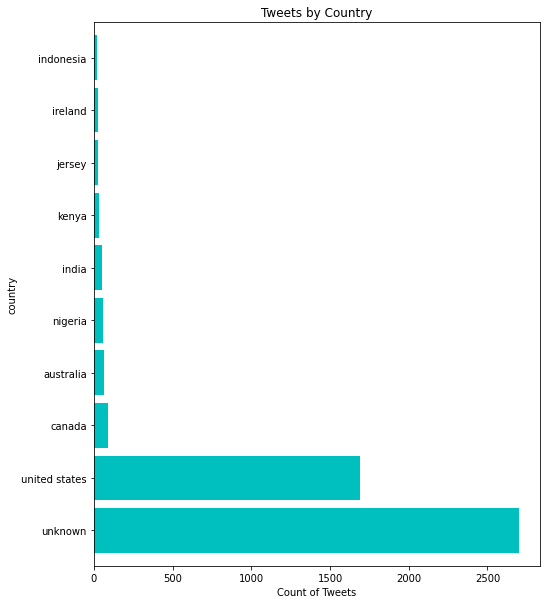

In [19]:
#visualize data 

top_10_ctry = ldf[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)
ax = top_10_ctry.plot(kind='barh', figsize=(8, 10), color='c', zorder=2, width=0.85, legend=None)
plt.title('Tweets by Country')
plt.xlabel('Count of Tweets')

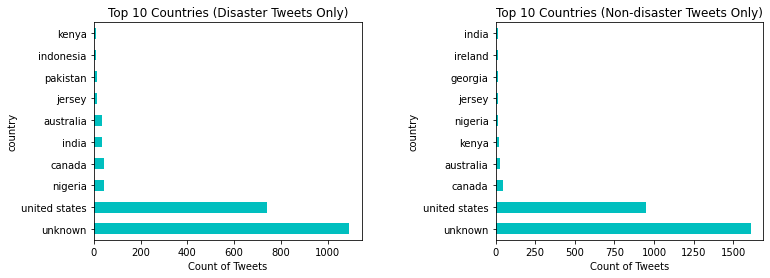

In [20]:
#segment and plot by tweet type

disaster_tweets = ldf.loc[df['target'] == 1]
dt = disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

non_disaster_tweets = ldf.loc[df['target'] == 0]
ndt = non_disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=.5)
#fig.suptitle('Tweets by Country')
dt.plot.barh(ax=ax1, color='c', legend=None)
ndt.plot.barh(ax=ax2, color='c', legend=None)

ax1.set_title('Top 10 Countries (Disaster Tweets Only)')
ax2.set_title('Top 10 Countries (Non-disaster Tweets Only)')
ax1.xaxis.set_label_text('Count of Tweets')
ax2.xaxis.set_label_text('Count of Tweets')
plt.show()


**Initial Observations:**

*   Dataset contains 7613 observations (i.e. rows) and 5 features (i.e. columns) 
*   Dataset contains missing values and spaces, indicated by NaN and %20 values  
*   There are 61 missing values under the keyword column 
*   There are 2533 missing values in the location column 
*   The training set shows an imbalance between classification types (i.e. tweet is/is not about a disaster) 
*   There are 110 duplicate tweets in the training set
*   Duplicate tweets are not always classified in the same way
*   Location data is not in a standard format
*   After attempting to clean the location data, the majority of tweets cannot be categorized by their country accurately. Most tweets irrespective of their classification stem from the United States, which likely a function of where Twitter's active user base lies vs. where the most disasters occur. 















In [21]:
#CREDIT TO SOURCES#
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/ 

# determine the most common words

#import 
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#import stop words
stop_words = set(stopwords.words('english'))
print(stop_words)

# tokenize the words from each tweet 
word_list = []
tweet_list = [word_tokenize(text_clean(tweet)) for tweet in train_d]

for tweet in tweet_list:
  cleaned_tweet = []
  for word in tweet: 
    word = text_clean(word)
    if word not in stop_words and word != '_':
      cleaned_tweet.append(word)
  word_list.append(cleaned_tweet)

#flatten list of words 
flat_list = list(itertools.chain(*word_list))

# count frequency of each word
word_freq = collections.Counter(flat_list)

# get top 20 words 
word_freq.most_common(21)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NameError: ignored

In [22]:
#set up data for models 

filter_td = drop_dup(train_data)

num_test = int(train_data.shape[0] * 0.8)

dev_data, dev_labels = filter_td.text[num_test:], filter_td.target[num_test:]
train_d, train_l = filter_td.text[:num_test], filter_td.target[:num_test]


In [207]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python
#https://stackoverflow.com/questions/43473736/most-common-2-grams-using-python

from collections import Counter
from nltk.util import ngrams
# nltk.download('stopwords')

#create dataframe
tweets = df[['text', 'target']]

#segment disaster tweets
dt = tweets.loc[df['target'] == 1]
dt.columns = ['text', 'target']
dt = dt['text']

#segment non-disaster tweets
ndt = tweets.loc[df['target'] == 0]
ndt.columns = ['text', 'target']
ndt = ndt['text']

def count_top_bigrams(tweets):
  #import stop words
  stop_words = set(stopwords.words('english'))

  #clean tweets
  clean_tweets = [word_tokenize(text_clean(tweet)) for tweet in tweets]

  #tokenize tweets and exclude stop words
  token_list = []

  for tweet in clean_tweets:
    tokens = []
    for token in tweet:
      if token not in stop_words:
        tokens.append(token)
    token_list.append(tokens)

  #group tokens as bigrams
  bigram_list = []

  for token in token_list: 
    bigram = list(ngrams(token, 2))
    bigram_list.append(bigram)

  #count bigrams
  cnt = collections.Counter()

  for tweet in bigram_list:
    for bigram in tweet:
      cnt.update(nltk.bigrams(bigram))

  top20 = cnt.most_common(20)
  return top20

#store output as dataframes
db = count_top_bigrams(dt)
disaster_bigrams = pd.DataFrame(db, columns=['bigram', 'count'])

ndb = count_top_bigrams(ndt)
non_disaster_bigrams = pd.DataFrame(ndb, columns=['bigram', 'count'])
print(non_disaster_bigrams)

                     bigram  count
0             (cross, body)     38
1          (liked, youtube)     35
2          (youtube, video)     35
3                 (gon, na)     32
4                 (wan, na)     30
5              (full, read)     28
6               (body, bag)     27
7                 (full, _)     25
8           (body, bagging)     23
9      (burning, buildings)     22
10            (looks, like)     21
11             (body, bags)     21
12     (reddit, quarantine)     21
13  (quarantine, offensive)     21
14             (feel, like)     20
15     (offensive, content)     20
16        (content, policy)     20
17           (via, youtube)     18
18              (fan, army)     17
19         (prebreak, best)     17


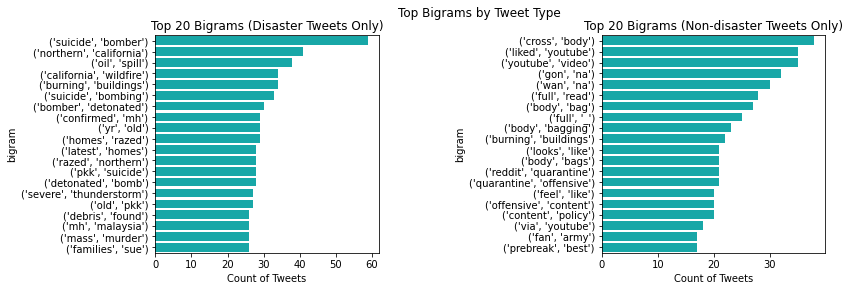

In [212]:
#segment and plot by tweet type
# print(disaster_bigrams)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=1)
fig.suptitle('Top Bigrams by Tweet Type')
sns.barplot(x = disaster_bigrams['count'], y = disaster_bigrams['bigram'], color='c', ax = axes[0])
sns.barplot(x = non_disaster_bigrams['count'], y = non_disaster_bigrams['bigram'], color='c', ax=axes[1])

axes[0].set_title('Top 20 Bigrams (Disaster Tweets Only)')
axes[1].set_title('Top 20 Bigrams (Non-disaster Tweets Only)')
axes[0].xaxis.set_label_text('Count of Tweets')
axes[1].xaxis.set_label_text('Count of Tweets')
plt.show()

In [35]:
#transform data
vectorizer = CountVectorizer(preprocessor=text_clean, stop_words='english')
vtrain = vectorizer.fit_transform(train_d)
vdev = vectorizer.transform(dev_data)


In [38]:
#produce logistic regression model
model_lr = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
start_time = time.time() 
model_lr.fit(vtrain, train_l)
train_predicted_labels_lr = model_lr.predict(vdev) 
stop_time = time.time()
total_time = stop_time - start_time
score_lr = metrics.f1_score(dev_labels, train_predicted_labels_lr, average='weighted')

score_lr, total_time

(0.7615959038539327, 0.05192303657531738)

In [68]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation
#https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
#https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-4-count-vectorizer-b3f4944e51b5 #look at this tmr

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(filter_td.text, filter_td.target , random_state=1, test_size =.20)
vectorizer = CountVectorizer(preprocessor=text_clean, stop_words='english')
ktrain = vectorizer.fit_transform(X_train)
ktest = vectorizer.transform(X_test)

model = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
model.fit(ktrain, y_train)
y_pred = model.predict(ktest)
metrics.f1_score(y_test, y_pred)
#metrics.accuracy_score(y_test, y_pred)

#note - mild improvement using train_test_split

0.7412467976088812

In [66]:
#CREDIT TO SOURCES
#https://stackoverflow.com/questions/62591306/applying-k-fold-validation-for-text-classification

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

X, y = filter_td.text, filter_td.target
metrics = []

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = CountVectorizer(preprocessor=text_clean, stop_words='english')
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    lr = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    lr.fit(X_train_dtm, y_train)
    y_pred_class = lr.predict(X_test_dtm)

    metrics.append(accuracy_score(y_test, y_pred_class))

metrics = np.array(metrics)
print('Mean accuracy: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))

#stratified k fold performed way worse

Mean accuracy:  0.6885672427077412
Std for accuracy:  0.04532189658216761


In [ ]:
#produce naive bayes model
nb_model = MultinomialNB()
start_time = time.time()  
nb_model.fit(vtrain, train_l)
nb_train_predicted_labels = nb_model.predict(vdev) 
stop_time = time.time()
total_time = stop_time - start_time
score_nb = metrics.f1_score(dev_labels, nb_train_predicted_labels, average='weighted')
score_nb, total_time

(0.7638446993948937, 0.005049943923950195)